# License

    Jupyter notebook for accessing CUDA
    Copyright (C) 2018 Andre.Brodtkorb@ifi.uio.no

    This program is free software: you can redistribute it and/or modify
    it under the terms of the GNU General Public License as published by
    the Free Software Foundation, either version 3 of the License, or
    (at your option) any later version.

    This program is distributed in the hope that it will be useful,
    but WITHOUT ANY WARRANTY; without even the implied warranty of
    MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
    GNU General Public License for more details.

    You should have received a copy of the GNU General Public License
    along with this program.  If not, see <http://www.gnu.org/licenses/>.

In [38]:
#Lets have matplotlib "inline"
%matplotlib inline

#Import packages we need
import numpy as np
import pycuda.compiler as cuda_compiler
from pycuda.gpuarray import GPUArray
import pycuda.driver as cuda_driver

from matplotlib import pyplot as plt

In [39]:
#Initialize CUDA - must be first call to CUDA!
cuda_driver.init()

In [40]:
#Create CUDA context
cuda_device = cuda_driver.Device(0)
print("Using '{:s}'".format(cuda_device.name()))
print(" => compute capability: {:s}".format(str(cuda_device.compute_capability())))
context = cuda_device.make_context()
free, total = cuda_driver.mem_get_info()
print(" => memory: {:d} / {:d} MB available".format(int(free/(1024*1024)), int(total/(1024*1024))))

Using 'Tesla K80'
 => compute capability: (3, 7)
 => memory: 9127 / 11441 MB available


In [41]:
cuda_kernel = """
__global__ void addVectorKernel(float* c, float* a, float* b) {
    unsigned int i = blockIdx.x*blockDim.x + threadIdx.x;
    c[i] = a[i] + b[i];
}
__global__ void addMatrixKernel(float* c, float* a, float* b, int cols){
unsigned int i = blockIdx.x*blockDim.x + threadIdx.x;
unsigned int j = blockIdx.y*blockDim.y + threadIdx.y;

        //Pseudocode
        //c[j,i] = a[j][i]+b[j][i]
        unsigned int k = j*cols + i;

c[k] = a[k]+b[k];

}
"""
module = cuda_compiler.SourceModule(cuda_kernel)
kernel = module.get_function("addMatrixKernel");

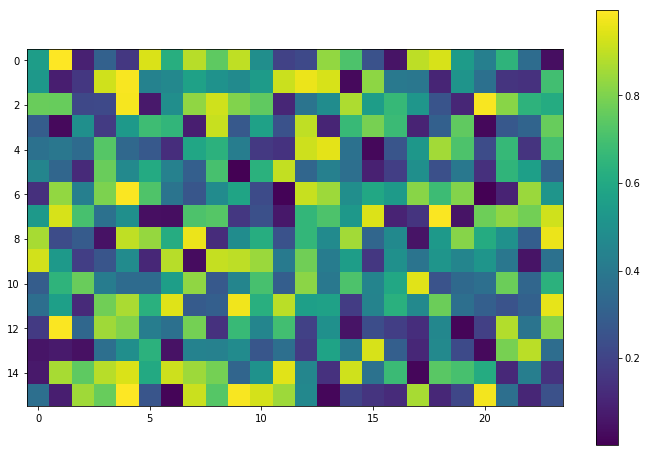

In [42]:
#Size of our test
test_size = (16,24)

#Create test input / output data
a = np.random.random(test_size).astype(np.float32)
b = np.random.random(test_size).astype(np.float32)
c = np.empty_like(a)

fig = plt.figure(figsize=(12,8))
plt.imshow(a)
plt.colorbar()
fig.show()

In [43]:
print(a.shape)

(16, 24)


In [44]:
#Upload data to the device
a_g = GPUArray(a.shape, np.float32)
b_g = GPUArray(b.shape, np.float32)
a_g.set(a)
b_g.set(b)

In [45]:
#Allocate output data
c_g = GPUArray(c.shape, np.float32)

In [46]:
#a is [rows,columns] = (y,x) but we need it in (x,y)

domain_size = (a.shape[1], a.shape[0]) #domain_size[0] is the number of columns now
block_size = (8,8,1)
grid_size = (domain_size[0] // block_size[0], domain_size[1] // block_size[1], 1)

 #'//' è la divisione intera
 # '/' è la divisione normale

print("Domain size is " + str(domain_size))
print("Block size is " + str(block_size))
print("Grid size is " + str(grid_size))

Domain size is (24, 16)
Block size is (8, 8, 1)
Grid size is (3, 2, 1)


In [47]:
#Execute program on device
kernel(c_g, a_g, b_g, np.int32(domain_size[0]), block=block_size, grid=grid_size)

#Copy data from device to host
c_g.get(c)

array([[1.1241971 , 1.5220989 , 0.5173185 , 1.0726295 , 0.94510293,
        1.7306765 , 0.9633421 , 1.5065099 , 1.0836952 , 1.18239   ,
        1.2768747 , 0.5191339 , 0.68166196, 1.1879001 , 1.6509006 ,
        1.1649107 , 0.7562908 , 1.4929423 , 1.0330817 , 1.4267114 ,
        0.4916733 , 1.0370488 , 0.45927167, 0.26383516],
       [1.2944652 , 0.4917872 , 1.1115639 , 1.2849076 , 1.1442709 ,
        0.89350295, 1.2874509 , 1.1494458 , 0.9890325 , 0.5226524 ,
        0.7214418 , 1.6404575 , 1.3330952 , 1.1908661 , 0.9221917 ,
        1.2373642 , 1.2533909 , 0.73814714, 0.7003822 , 0.5318042 ,
        0.81742394, 0.20262069, 0.83630645, 1.3181387 ],
       [1.5759813 , 0.80001074, 0.65371454, 0.5241113 , 1.7264493 ,
        0.9335948 , 1.2824757 , 1.715093  , 1.0238986 , 1.0159134 ,
        1.6423646 , 0.9354539 , 0.7438171 , 1.1283629 , 1.2316632 ,
        1.006345  , 1.0707564 , 1.3171649 , 0.52662873, 0.61979055,
        1.2043972 , 1.3754098 , 1.2166221 , 1.051923  ],
       [0.792

In [48]:
#Compute reference using Numpy
c_ref = a + b

#Print result
print("C   = ", c)
print("Ref = ", c_ref)
print("Sad = ", np.sum(np.abs(c - c_ref)))

C   =  [[1.1241971  1.5220989  0.5173185  1.0726295  0.94510293 1.7306765
  0.9633421  1.5065099  1.0836952  1.18239    1.2768747  0.5191339
  0.68166196 1.1879001  1.6509006  1.1649107  0.7562908  1.4929423
  1.0330817  1.4267114  0.4916733  1.0370488  0.45927167 0.26383516]
 [1.2944652  0.4917872  1.1115639  1.2849076  1.1442709  0.89350295
  1.2874509  1.1494458  0.9890325  0.5226524  0.7214418  1.6404575
  1.3330952  1.1908661  0.9221917  1.2373642  1.2533909  0.73814714
  0.7003822  0.5318042  0.81742394 0.20262069 0.83630645 1.3181387 ]
 [1.5759813  0.80001074 0.65371454 0.5241113  1.7264493  0.9335948
  1.2824757  1.715093   1.0238986  1.0159134  1.6423646  0.9354539
  0.7438171  1.1283629  1.2316632  1.006345   1.0707564  1.3171649
  0.52662873 0.61979055 1.2043972  1.3754098  1.2166221  1.051923  ]
 [0.79202545 0.41259938 1.0848365  0.8811059  0.70562357 1.6192234
  0.93569803 0.74829423 1.608929   1.2546779  0.85401964 0.30375955
  1.6548097  0.34362388 1.2790265  1.3255036  

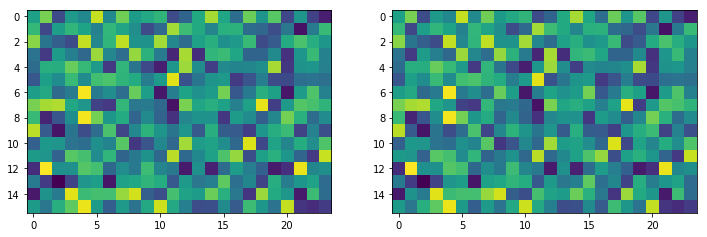

In [49]:
fig = plt.figure(figsize = (12,8))
plt.subplot(1,2,1)
plt.imshow(c)
plt.subplot(1,2,2)
plt.imshow(c_ref)

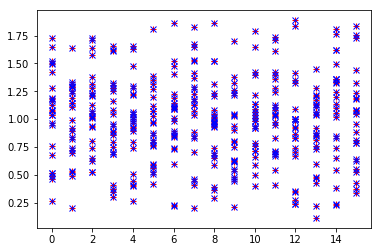

In [50]:
plt.figure()
plt.plot(c, '+r')
plt.plot(c_ref, 'xb')